# < Synthetic Data - FULL>
- synthtiger 이용
`synthtiger -o results -w 4 Synth/synthtiger/examples/mytiger/template.py SynthTiger Synth/synthtiger/examples/mytiger/config_horizontal.yaml -c 187947`

In [1]:
%load_ext lab_black

In [2]:
import glob
import os
import string

import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.io import read_image

In [3]:
def get_file_index(x):
    """Get file index from file name

    Args:
        x (str): _description_

    Returns:
        tuple: tuple containing
            int: file index1
            int: file index2
    """
    idx1 = int(os.path.basename(x).split("_")[0])
    idx2 = int(os.path.basename(x).split("_")[1].split(".")[0])
    return idx1, idx2


# 0_0.jpg
img_list = sorted(glob.glob("Synth/synthtiger/results/images/*/*"), key=get_file_index)
print(len(img_list))
img_list[:10]

375894


['Synth/synthtiger/results/images/0/0_0.jpg',
 'Synth/synthtiger/results/images/0/0_1.jpg',
 'Synth/synthtiger/results/images/0/1_0.jpg',
 'Synth/synthtiger/results/images/0/1_1.jpg',
 'Synth/synthtiger/results/images/0/2_0.jpg',
 'Synth/synthtiger/results/images/0/2_1.jpg',
 'Synth/synthtiger/results/images/0/3_0.jpg',
 'Synth/synthtiger/results/images/0/3_1.jpg',
 'Synth/synthtiger/results/images/0/4_0.jpg',
 'Synth/synthtiger/results/images/0/4_1.jpg']

In [4]:
with open("Synth/synthtiger/results/gt.txt", "r") as f:
    tiger_gt = f.readlines()

In [5]:
tiger_gt[:10]
gt_tiger = [x.rstrip().split("\t") for x in tiger_gt]
gt_tiger[:5]

[['images\\0\\0_0.jpg', 'goodman'],
 ['images\\0\\0_1.jpg', 'UNDERLIP'],
 ['images\\0\\1_0.jpg', 'marriageable'],
 ['images\\0\\1_1.jpg', 'Scarred'],
 ['images\\0\\2_0.jpg', 'THE']]

In [6]:
class LabelConverterAtt:
    """Convert label into Attention Format"""

    def __init__(self):
        self.max_len = 15
        character = list(string.printable[:-5])
        list_token = ["[GO]", "[s]"]
        self.character = list_token + character
        self.dictionary = {}

        for i, char in enumerate(self.character):
            self.dictionary[char] = i

    def encode(self, text):
        encoded = torch.LongTensor(1, self.max_len + 2).fill_(0)  # N: 1(batch)
        text = list(text)
        text.append("[s]")
        text = [self.dictionary[char] for char in text]
        encoded[0][1 : 1 + len(text)] = torch.LongTensor(text)
        return encoded[0]

    def decode(self, t):
        text = "".join([self.character[i] for i in t if i > 1])
        return text

In [7]:
class TigerDataset(Dataset):
    """
    Tiger Dataset with Image and text
    """

    def __init__(
        self,
        img_path="Synth/synthtiger/results/images",
        gt_path="Synth/synthtiger/results/gt.txt",
        transform=None,
        encode=True,
    ):
        with open(gt_path) as f:
            self.gt_tiger = f.readlines()
        self.gt_tiger = [x.rstrip().split("\t") for x in self.gt_tiger]
        self.img_path_lst = sorted(glob.glob(img_path + "/*/*"), key=get_file_index)
        self.transform = transform
        self.preprocess = transforms.Compose(
            [
                transforms.ToPILImage(),
                transforms.Resize((32, 128)),
                transforms.ToTensor(),
            ]
        )
        self.converter = LabelConverterAtt()
        self.encode = encode

    def __len__(self):
        return len(self.gt_tiger) // 2

    def __getitem__(self, idx):
        index = idx * 2

        image1 = read_image(self.img_path_lst[index])
        image2 = read_image(self.img_path_lst[index + 1])

        image1 = self.preprocess(image1)
        image2 = self.preprocess(image2)

        label1 = self.gt_tiger[index][1]
        label2 = self.gt_tiger[index + 1][1]
        length1 = len(label1)

        if self.encode:
            label1 = self.converter.encode(label1)
            length1 += 1

        if self.transform:
            image1 = self.transform(image1)
            image2 = self.transform(image2)
        return image1, label1, image2, label2, length1

In [8]:
tiger_dataset = TigerDataset(encode=False)
tiger_dataloader = DataLoader(tiger_dataset)

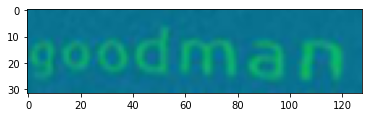

('goodman',)


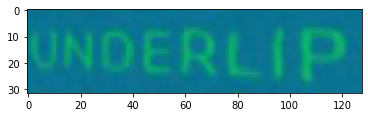

('UNDERLIP',)


In [9]:
tiger_iter = iter(tiger_dataloader)
img1, label1, img2, label2, length1 = next(tiger_iter)
img1 = img1[0].permute(1, 2, 0)
plt.imshow(img1)
plt.show()
print(label1)

img2 = img2[0].permute(1, 2, 0)
plt.imshow(img2)
plt.show()
print(label2)

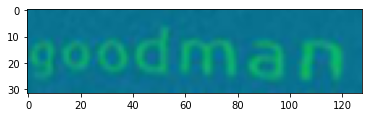

tensor([[ 0, 18, 26, 26, 15, 24, 12, 25,  1,  0,  0,  0,  0,  0,  0,  0,  0]])


In [10]:
tiger_dataset = TigerDataset()
tiger_dataloader = DataLoader(tiger_dataset)
img1, label1, img2, label2, length1 = next(iter(tiger_dataloader))
img1 = img1[0].permute(1, 2, 0)
plt.imshow(img1)
plt.show()
print(label1)

In [11]:
converter = LabelConverterAtt()
print(converter.character)
print(converter.dictionary)
encoded = converter.encode("goguma")
print(encoded)
print(len(encoded))
print(converter.decode(encoded))

['[GO]', '[s]', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', ':', ';', '<', '=', '>', '?', '@', '[', '\\', ']', '^', '_', '`', '{', '|', '}', '~', ' ']
{'[GO]': 0, '[s]': 1, '0': 2, '1': 3, '2': 4, '3': 5, '4': 6, '5': 7, '6': 8, '7': 9, '8': 10, '9': 11, 'a': 12, 'b': 13, 'c': 14, 'd': 15, 'e': 16, 'f': 17, 'g': 18, 'h': 19, 'i': 20, 'j': 21, 'k': 22, 'l': 23, 'm': 24, 'n': 25, 'o': 26, 'p': 27, 'q': 28, 'r': 29, 's': 30, 't': 31, 'u': 32, 'v': 33, 'w': 34, 'x': 35, 'y': 36, 'z': 37, 'A': 38, 'B': 39, 'C': 40, 'D': 41, 'E': 42, 'F': 43, 'G': 44, 'H': 45, 'I': 46, 'J': 47, 'K': 48, 'L': 49, 'M': 50, 'N': 51, 'O': 52, 'P': 53, 'Q': 54, 'R': 55, 'S': 56,

In [ ]:
def get_stat_synth(dataset):
    loader = DataLoader(dataset, batch_size=len(dataset))
    data = next(iter(loader))
    inputs = torch.cat([data[0], data[2]], 0)

    mean = [0] * 3
    std = [0] * 3

    for i in range(3):
        mean[i] = torch.mean(inputs[:, i, :, :])
        std[i] = torch.std(inputs[:, i, :, :])
    return mean, std


tiger_dataset = TigerDataset()
mean, std = get_stat_synth(tiger_dataset)
print(mean, std)

In [ ]:
tiger_dataset = TigerDataset(transform=transforms.Normalize(mean, std))
torch.save(tiger_dataset, "dataset/synth_187k.pt")

In [ ]:
temp = torch.load("dataset/synth_187k.pt")
temp[0][0].shape

In [ ]:
temp_new = temp[0][0] - temp[0][0].min()
temp_new = temp_new / temp_new.max()
plt.imshow(temp_new[0].permute(1, 2, 0))

In [ ]:
temp_new = temp[0][2] - temp[0][2].min()
temp_new = temp_new / temp_new.max()
plt.imshow(temp_new[0].permute(1, 2, 0))

In [ ]:
len(tiger_dataset)